# Test different interpolations

In [5]:
%load_ext autoreload
%autoreload 1
import numpy as np
import scipy.special as special
import scipy.integrate as integrate
import matplotlib.pyplot as plt
# fake beta function
def special_beta(alpha, beta): return special.gamma(alpha)*special.gamma(beta)/special.gamma(alpha+beta)

In [20]:
import eko.dglap as dglap
import eko.interpolation as interpolation
import eko.Mellin as Mellin
%aimport eko.dglap
%aimport eko.interpolation
%aimport eko.Mellin

In [7]:
def get_toy_pdf_x(alpha, beta):
    """test fnc in x"""
    return lambda x,alpha=alpha,beta=beta: x**alpha * (1-x)**beta
def get_toy_pdf_N(alpha, beta):
    return lambda N: special_beta(N+alpha,beta+1)

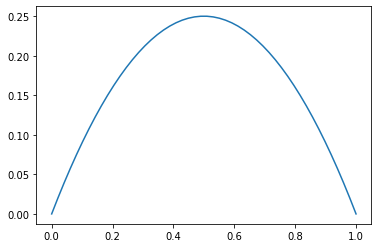

In [8]:
xs = np.linspace(0,1)
ys = get_toy_pdf_x(1,1)(xs)
plt.plot(xs,ys)
plt.show()

In [9]:
def get_linear_interpolators_x(x,xgrid,j):
    """get j-th linear interpolator of grid"""
    l = len(xgrid)
    if l < 2 : raise "need at least 2 points"
    if 0 == j: return (xgrid[1]-x)/(xgrid[1]) if x <= xgrid[1] else 0.
    if l - 1 == j: return (x-xgrid[-2])/(xgrid[-1] - xgrid[-2]) if x >= xgrid[-2] else 0.
    if (xgrid[j]-x)*(x-xgrid[j-1]) > 0:
        return (x-xgrid[j-1])/(xgrid[j]-xgrid[j-1])
    if (xgrid[j]-x)*(x-xgrid[j+1]) >= 0:
        return (xgrid[j+1]-x)/(xgrid[j+1]-xgrid[j])
    return 0.

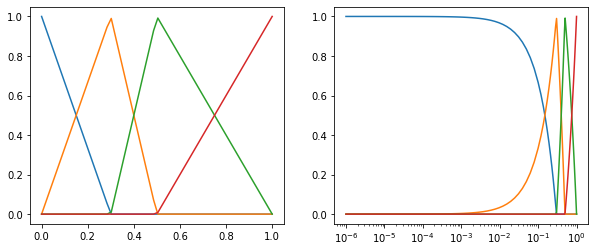

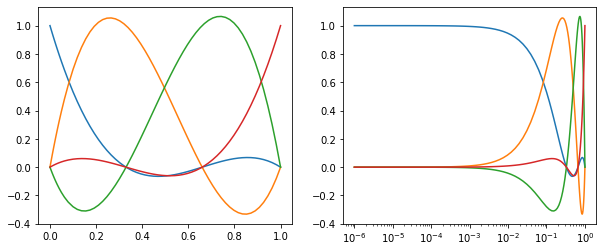

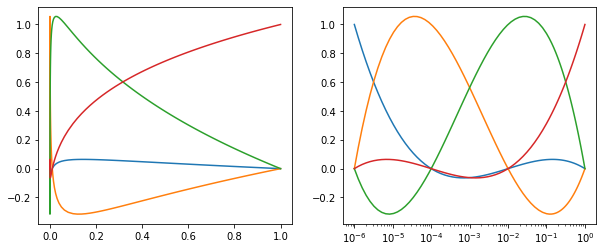

In [10]:
def plot_interpolators_x(f,g,xmin=1e-6):
    """plot all linear interpolators of grid"""
    xs = np.append(np.logspace(np.log10(xmin),-1),np.linspace(0.1,1.))
    plt.figure(figsize=(10,4))
    plt.title("all interpolators p_j(x)")
    plt.subplot(1,2,1)
    for j in range(len(g)):
        ys = [f(x,g,j) for x in xs]
        plt.plot(xs,ys)
    plt.subplot(1,2,2)
    for j in range(len(g)):
        ys = [f(x,g,j) for x in xs]
        plt.semilogx(xs,ys)
    plt.show()

plot_interpolators_x(get_linear_interpolators_x,[0.,.3,.5,1.])
plot_interpolators_x(interpolation.get_Lagrange_interpolators_x,[0.,.33,.66,1.])
plot_interpolators_x(interpolation.get_Lagrange_interpolators_log_x,[1e-6,1e-4,1e-2,1.])

In [11]:
def plot_dist(x,y,yref):
    """compare to distributions both in linear and logarithmic x-space"""
    plt.figure(figsize=(15,5))
    plt.subplot(2,3,1)
    plt.title("small x")
    plt.semilogx(x,y,"o")
    plt.semilogx(x,yref,"x")
    plt.subplot(2,3,4)
    plt.loglog(x,np.abs((y - yref)/yref),"x")
    plt.subplot(2,3,2)
    plt.title("linear x")
    plt.plot(x,y,"o")
    plt.plot(x,yref,"x")
    plt.subplot(2,3,5)
    plt.semilogy(x,np.abs((y - yref)/yref),"x")
    oMx = 1 - x
    ax = plt.subplot(2,3,3)
    ax.set_xlim(1e-3,.1)
    plt.title("large x, i.e. small (1-x)")
    plt.loglog(oMx,y,"o")
    plt.loglog(oMx,yref,"x")
    ax = plt.subplot(2,3,6)
    ax.set_xlim(1e-3,.1)
    plt.loglog(oMx,np.abs((y - yref)/yref),"x")
    plt.xlabel("1-x")

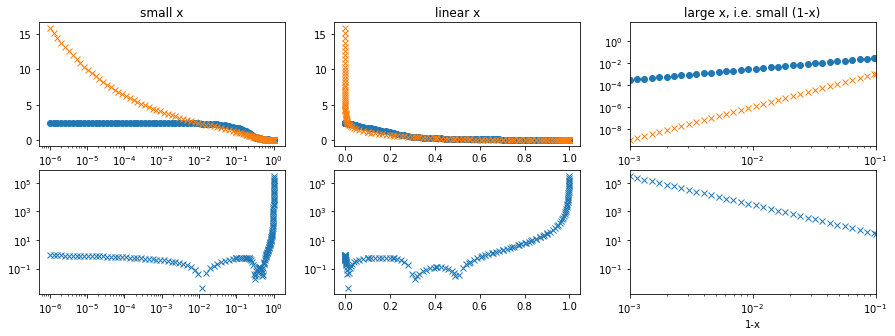

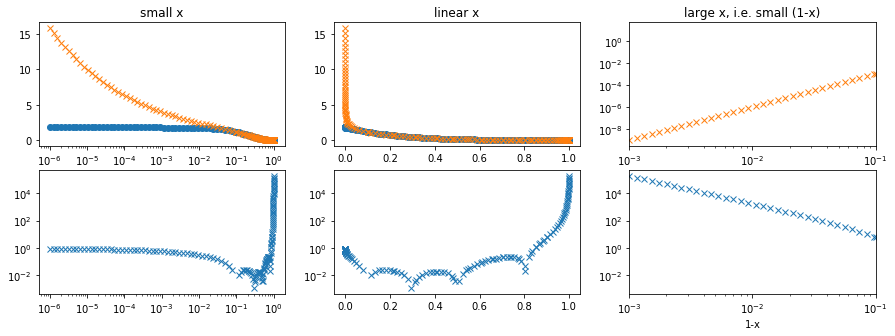

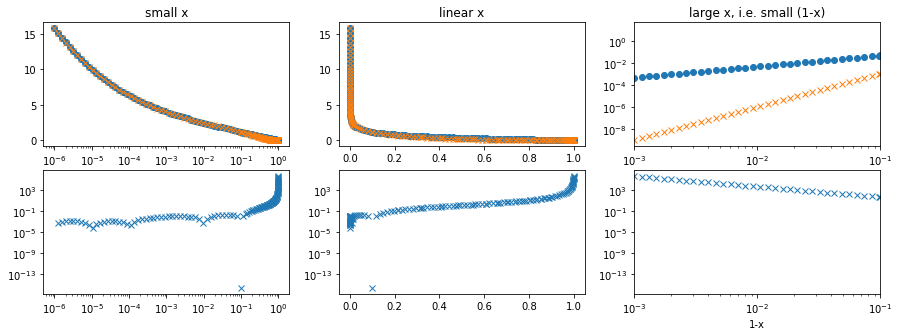

In [12]:
def test_interpolation_x(f,p,g,xmin=1e-6):
    """plots interpolation vs real thing in x"""
    fs = [f(x) for x in g]
    fp = lambda y,g=g,fs=fs: np.sum([fs[j]*p(y,g,j) for j in range(len(g))])

    oMx = 1.0 - np.logspace(-3,np.log10(.9))
    xs = np.append(np.logspace(np.log10(xmin),-1),[np.linspace(0.1,.9),oMx])
    xs = np.sort(xs)
    yref = np.array([f(x) for x in xs])
    y = np.array([fp(x) for x in xs])

    plot_dist(xs,y,yref)

toy_alpha = -.2
toy_beta = 3.
test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), get_linear_interpolators_x, [.01,.3,.5,1.])
test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), interpolation.get_Lagrange_interpolators_x, [.1,.3,.5,.8,1.])
test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), interpolation.get_Lagrange_interpolators_log_x, [1e-6,1e-5,1e-4,1e-2,1e-1,1.])

In [13]:
def Mellin_transform(f,N):
    """straight implementation of the Mellin transform"""
    r,re = integrate.quad(lambda x,f=f,N=N: np.real(x**(N-1)*f(x)),0,1)
    i,ie = integrate.quad(lambda x,f=f,N=N: np.imag(x**(N-1)*f(x)),0,1)
    return np.complex(r,i),np.complex(re,ie)

In [14]:
toy_alpha = 2.3
toy_beta = .5
for c in [np.complex(2,2),np.complex(2,-2),np.complex(-1,2)]:
    e = get_toy_pdf_N(toy_alpha,toy_beta)(c)
    i,ie = Mellin_transform(get_toy_pdf_x(toy_alpha,toy_beta),c)
    print("exact = ",e,", int = ",i,", |rel_err| = ",np.abs((e-i)/e))

exact =  (0.06506938494905695-0.046801971951956206j) , int =  (0.0650693849441131-0.04680197194966553j) , |rel_err| =  6.797962151083868e-11
exact =  (0.06506938494905695+0.046801971951956206j) , int =  (0.0650693849441131+0.04680197194966553j) , |rel_err| =  6.797962151083868e-11
exact =  (0.041834527464115055-0.21549284638271926j) , int =  (0.041834527409332224-0.21549284630671234j) , |rel_err| =  4.268121107916933e-10


In [16]:
g = [0.,.5,1.]
for k in range(len(g)):
    for c in [np.complex(2,2),np.complex(2,-2),np.complex(-1,2)]:
        e = interpolation.get_Lagrange_interpolators_N(c,g,k)
        i,ie = Mellin_transform(lambda x: interpolation.get_Lagrange_interpolators_x(x,g,k),c)
        print("exact = ",e,", int = ",i,", |rel_err| = ",np.abs((e-i)/e))

exact =  (-0.04230769230769227+0.011538461538461553j) , int =  (-0.042307691866726164+0.011538461538452381j) , |rel_err| =  1.0055574301762228e-08
exact =  (-0.04230769230769227-0.011538461538461553j) , int =  (-0.042307691866726164-0.011538461538452381j) , |rel_err| =  1.0055574301762228e-08
exact =  (0.2+0.30000000000000004j) , int =  (0.19999999975547797+0.29999999959768586j) , |rel_err| =  1.3057497987283011e-09
exact =  (0.12307692307692308-0.2153846153846154j) , int =  (0.12307692307791729-0.2153846153792987j) , |rel_err| =  2.180376900395882e-11
exact =  (0.12307692307692308+0.2153846153846154j) , int =  (0.12307692307791729+0.2153846153792987j) , |rel_err| =  2.180376900395882e-11
exact =  (-0.8-0.3999999999999999j) , int =  (-0.8000000000000056-0.3999999999999926j) , |rel_err| =  1.0277811322930146e-14
exact =  (0.16923076923076924-0.046153846153846156j) , int =  (0.16923076924086644-0.04615384615517567j) , |rel_err| =  5.805975165046727e-11
exact =  (0.16923076923076924+0.046

In [17]:
g = [1e-4,1e-2,1.]
for k in range(len(g)):
    for c in [1,2,3,np.complex(2,2),np.complex(2,-2)]:
        e = interpolation.get_Lagrange_interpolators_log_N(c,g,k)
        i,ie = Mellin_transform(lambda x: interpolation.get_Lagrange_interpolators_log_x(x,g,k),c)
        print("exact = ",e,", int = ",i,", |rel_err| = ",np.abs((e-i)/e))

exact =  -0.06142069622290948 , int =  (-0.06142069622290945+0j) , |rel_err| =  4.518928850122067e-16
exact =  -0.021249289587340306 , int =  (-0.021249289587340316+0j) , |rel_err| =  4.898206508542206e-16
exact =  -0.010317331006464274 , int =  (-0.010317331013046604+0j) , |rel_err| =  6.379876891526935e-10
exact =  (-0.0014735288829032342+0.012098173676573388j) , int =  (-0.001473528875837464+0.012098173701495102j) , |rel_err| =  2.1254421086993525e-09
exact =  (-0.0014735288829032342-0.012098173676573388j) , int =  (-0.001473528875837464-0.012098173701495102j) , |rel_err| =  2.1254421086993525e-09
exact =  0.3399886333974449 , int =  (0.3399886333974448+0j) , |rel_err| =  3.2654710056948044e-16
exact =  0.0967853894125871 , int =  (0.09678538941258709+0j) , |rel_err| =  1.4338721879450978e-16
exact =  0.044762133229775874 , int =  (0.04476213324233134+0j) , |rel_err| =  2.8049296821440686e-10
exact =  (0.0029470577658064685-0.05133975247210002j) , int =  (0.002947057549180235-0.0513

In [18]:
def inverse_Mellin_transform(f,path,jac,x,cut=0.):
    """inverse Mellin transformation"""
    return integrate.quad(lambda u,f=f,path=path,jac=jac,x=x: np.real(np.complex(0.,-1./(2.*np.pi))*np.exp(-path(u)*np.log(x)) * f(path(u)) * jac(u)), cut, 1.-cut)

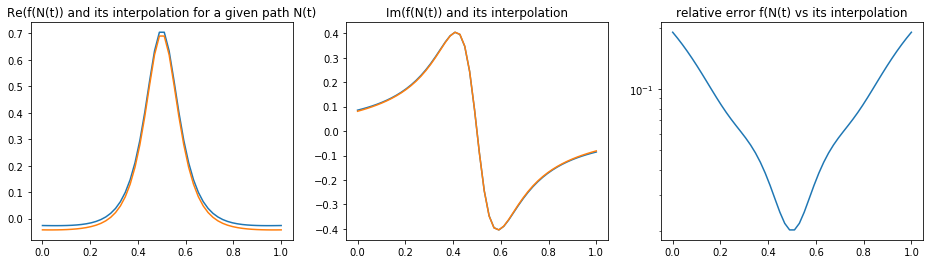

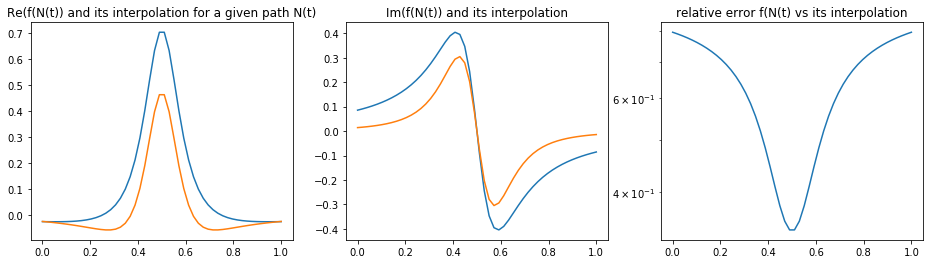

In [21]:
def test_interpolation_N(fx,fN,pN,g,path,ts = np.linspace(0,1)):
    """plots interpolation to real thing in x"""
    fxs = [fx(x) for x in g]
    fNp = lambda N,g=g,fxs=fxs: np.sum([fxs[j]*pN(N,g,j) for j in range(len(g))])
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.title("Re(f(N(t)) and its interpolation for a given path N(t)")
    ys = [fN(path(t)) for t in ts]
    yps = [fNp(path(t)) for t in ts]
    plt.plot(ts,np.real(ys))
    plt.plot(ts,np.real(yps))
    plt.subplot(1,3,2)
    plt.title("Im(f(N(t)) and its interpolation")
    plt.plot(ts,np.imag(ys))
    plt.plot(ts,np.imag(yps))
    plt.subplot(1,3,3)
    plt.title("relative error f(N(t) vs its interpolation")
    plt.semilogy(ts,[np.abs((ys[j] - yps[j])/ys[j]) for j in range(len(xs))])
    plt.show()

toy_alpha = 0.0
toy_beta = .4
p,j = Mellin.get_path_line(5)
test_interpolation_N(get_toy_pdf_x(toy_alpha,toy_beta),
                    get_toy_pdf_N(toy_alpha,toy_beta),
                    interpolation.get_Lagrange_interpolators_N,
                    np.linspace(0,1,num=5),
                    p
                    )
test_interpolation_N(get_toy_pdf_x(toy_alpha,toy_beta),
                    get_toy_pdf_N(toy_alpha,toy_beta),
                    interpolation.get_Lagrange_interpolators_log_N,
                    np.logspace(-6,0,num=6),
                    p
                    )

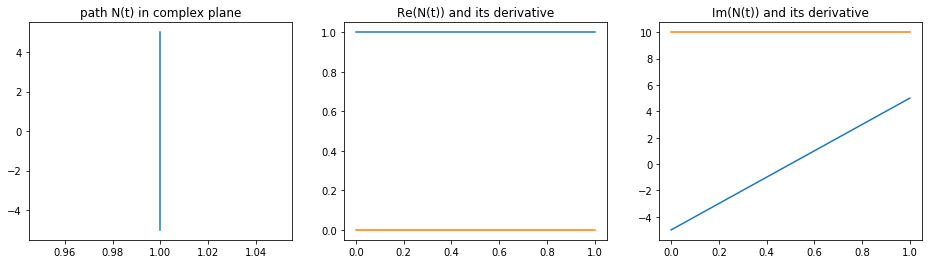

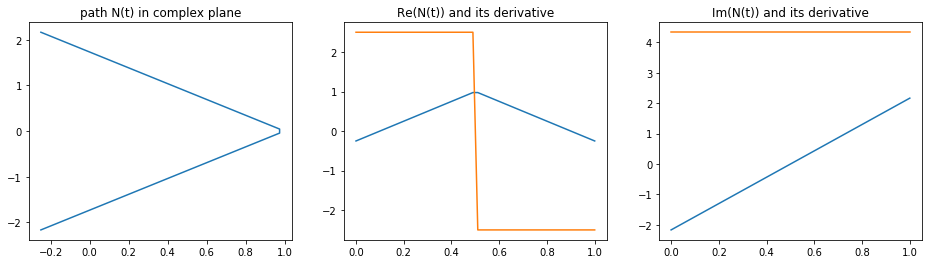

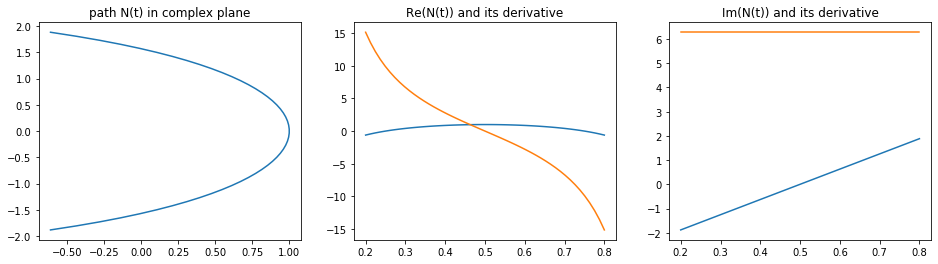

In [22]:
def plot_path(path,jac,plot_ts = np.linspace(0.,1)):
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.title("path N(t) in complex plane")
    ps = [path(t) for t in plot_ts]
    plt.plot(np.real(ps),np.imag(ps))
    plt.subplot(1,3,2)
    plt.title("Re(N(t)) and its derivative")
    pds = [jac(t) for t in plot_ts]
    plt.plot(plot_ts,np.real(ps))
    plt.plot(plot_ts,np.real(pds))
    plt.subplot(1,3,3)
    plt.title("Im(N(t)) and its derivative")
    plt.plot(plot_ts,np.imag(ps))
    plt.plot(plot_ts,np.imag(pds))
    plt.show()

p,j = Mellin.get_path_line(5)
plot_path(p,j)
p,j = Mellin.get_path_edge(5)
plot_path(p,j)
p,j = Mellin.get_path_Talbot()
plot_path(p,j,np.linspace(.2,.8))

/home/felix/Physik/N3PDF/EKO/eko/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  This is separate from the ipykernel package so we can avoid doing imports until


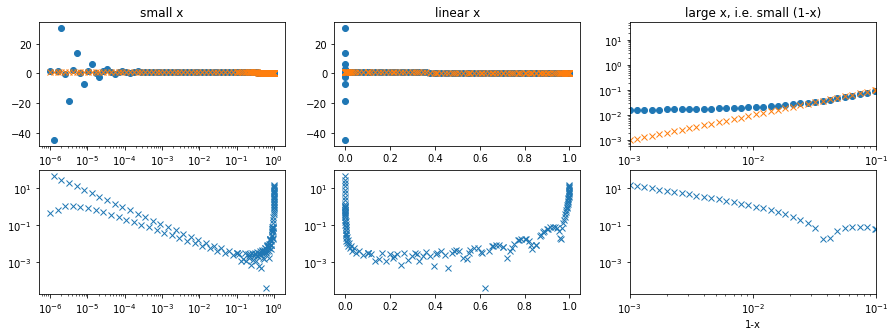

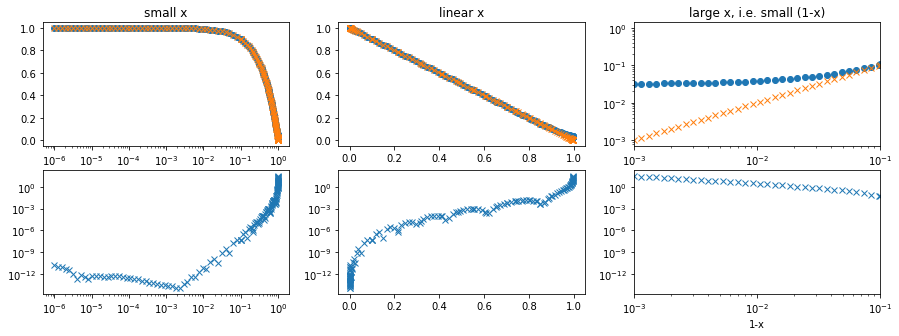

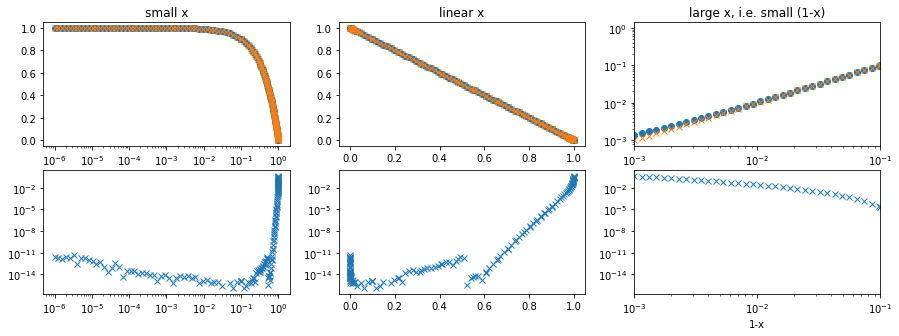

In [25]:
def test_inverse_Mellin_transform(fx,fN,path,jac,cut=0.,xmin=1e-6):
    """plot Mellin integration path and compare numeric inversion to real thing"""
    oMx = 1.0 - np.logspace(-3,np.log10(.9))
    xs = np.append(np.logspace(np.log10(xmin),-1),[np.linspace(0.1,.9),oMx])
    xs = np.sort(xs)
    ys = [fx(x) for x in xs]
    yps = [inverse_Mellin_transform(fN,path,jac,x,cut) for x in xs]
    if isinstance(yps[0],tuple):
        yps = [yp[0] for yp in yps]

    plot_dist(xs,np.array(yps),np.array(ys))

toy_alpha = 0
toy_beta = 1
p,j = Mellin.get_path_line(20)
test_inverse_Mellin_transform(get_toy_pdf_x(toy_alpha,toy_beta),get_toy_pdf_N(toy_alpha,toy_beta),p,j)
p,j = Mellin.get_path_edge(20)
test_inverse_Mellin_transform(get_toy_pdf_x(toy_alpha,toy_beta),get_toy_pdf_N(toy_alpha,toy_beta),p,j)
p,j = Mellin.get_path_Talbot()
test_inverse_Mellin_transform(get_toy_pdf_x(toy_alpha,toy_beta),get_toy_pdf_N(toy_alpha,toy_beta),p,j,1e-2)

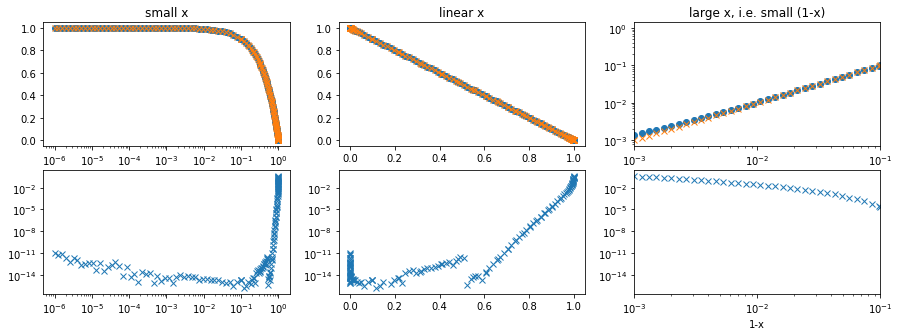

In [26]:
def test_inv_interpolation_x(fx,pN,g,path,jac,cut=0.):
    """compare interpolated numeric inversion to real thing"""
    fxs = [fx(x) for x in g]
    fNp = lambda N,pN=pN,g=g,fxs=fxs: np.sum([fxs[j]*pN(N,g,j) for j in range(len(g))])
    return test_inverse_Mellin_transform(fx,fNp,path,jac,cut)

p,j = Mellin.get_path_Talbot()
test_inv_interpolation_x(get_toy_pdf_x(0.,1.),
                     interpolation.get_Lagrange_interpolators_N,
                     [0.,.5,1.],
                     p,j,1e-2
                     )

[0.01253604390908819, 0.1090842587659851, 0.2830581304412209, 0.49999999999999994, 0.716941869558779, 0.890915741234015, 0.9874639560909118]


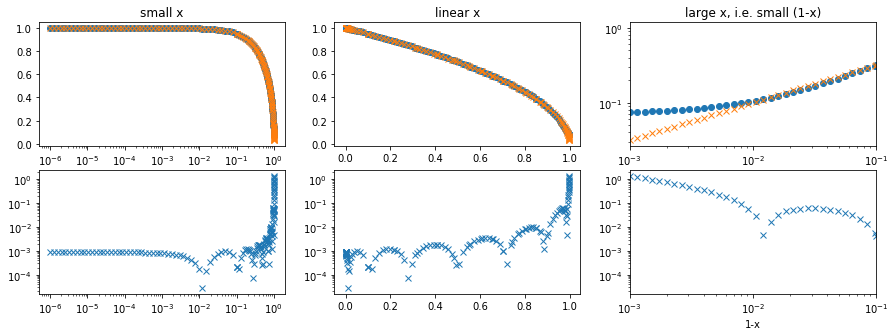

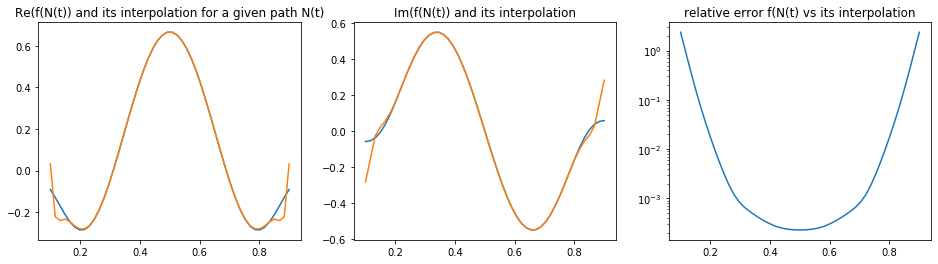

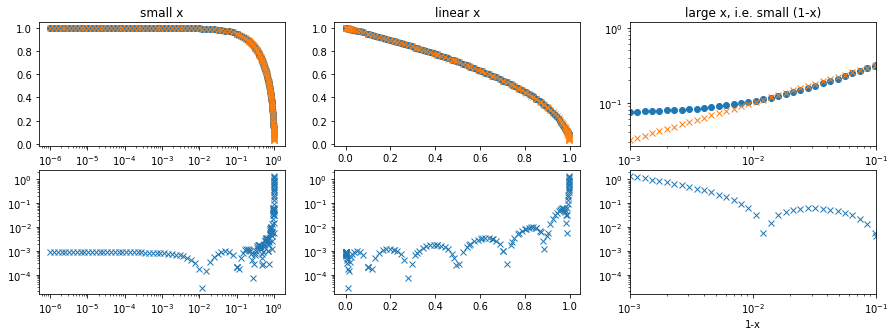

In [28]:
toy_alpha = 0.
toy_beta = .5
#g = np.linspace(0.,1.,num=7)
n_points = 7
g = [.5 - .5*np.cos((2.*j+1)/(2.*n_points)*np.pi) for j in range(n_points)]
print(g)
test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),
                    interpolation.get_Lagrange_interpolators_x,
                    g)
p,j = Mellin.get_path_Talbot()
#plot_path(p,j,np.linspace(.2,.8))
test_interpolation_N(get_toy_pdf_x(toy_alpha,toy_beta),
                    get_toy_pdf_N(toy_alpha,toy_beta),
                    interpolation.get_Lagrange_interpolators_N,
                    g,
                    p,
                    np.linspace(.1,.9))
test_inv_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),
                         interpolation.get_Lagrange_interpolators_N,
                         g,
                         p,j,
                         1e-2
                        )

[1.189094207336904e-06, 4.513417958554193e-06, 4.992853033786162e-05, 0.000999999999999999, 0.020028628786649537, 0.2215615768765043, 0.8409762606106714]


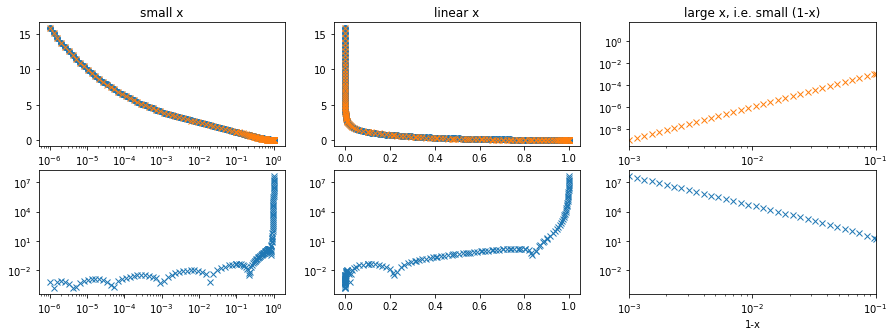

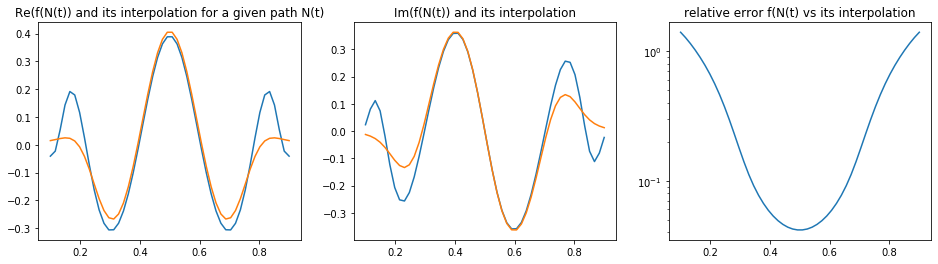

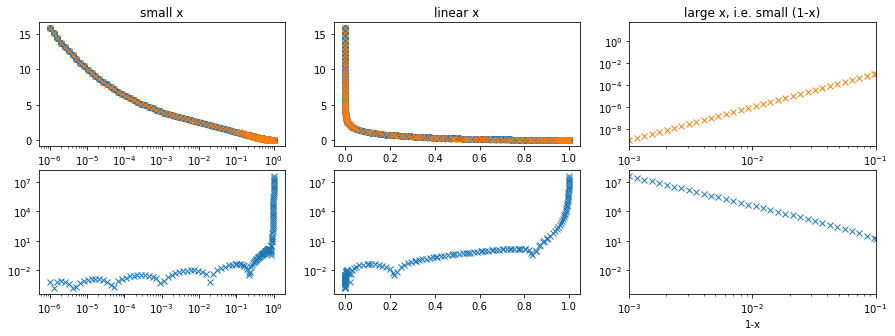

In [30]:
toy_alpha = -0.2
toy_beta = 3.
n_points = 7
#g = np.linspace(0.,1.,num=n_points)
#g = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1.0]
g = [.5 - .5*np.cos((2.*j+1)/(2.*n_points)*np.pi) for j in range(n_points)]
g = [10.**(-6. + 6.*e) for e in g]
print(g)
test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),
                    interpolation.get_Lagrange_interpolators_log_x,
                    g)
#p,j = get_path_line(10)
p,j = Mellin.get_path_Talbot()
#plot_path(p,j,np.linspace(.2,.8))
test_interpolation_N(get_toy_pdf_x(toy_alpha,toy_beta),
                    get_toy_pdf_N(toy_alpha,toy_beta),
                    interpolation.get_Lagrange_interpolators_log_N,
                    g,
                    p,
                    np.linspace(.1,.9))
test_inv_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),
                         interpolation.get_Lagrange_interpolators_log_N,
                         g,
                         p,j,
                         1e-2
                        )